In [1]:
import numpy as np
import pandas as pd

# Data visualisation packages
import folium
import matplotlib.pyplot as plt

# Web scraping packages
import requests
from bs4 import BeautifulSoup

# Data Collection
## Foursquare API Set-Up

In [2]:
CLIENT_ID = 'AULYSY33DL23251P3XKEUCT0EQWTDGEOAI53K33TDTRPB15K' # your Foursquare ID
CLIENT_SECRET = 'RC55JFMYD2IWPJWSVH00BTYUH4LNIOYIVIL12O4EZOX3RDF5' # your Foursquare Secret
VERSION = '20200428'
LIMIT = 50

print('Foursquare ID:    ', CLIENT_ID)
print('Foursquare Secret:', CLIENT_SECRET)

Foursquare ID:     AULYSY33DL23251P3XKEUCT0EQWTDGEOAI53K33TDTRPB15K
Foursquare Secret: RC55JFMYD2IWPJWSVH00BTYUH4LNIOYIVIL12O4EZOX3RDF5


In [3]:
def foursquare_search(CLIENT_ID = CLIENT_ID, CLIENT_SECRET = CLIENT_SECRET, VERSION = VERSION, latitude = '49.8681', longitude = '6.1567', search_query = '', radius = 10000, LIMIT = LIMIT):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, search_query, radius, LIMIT)
    results = requests.get(url).json()
    
    # Put results into a dataframe
    try:
        response = pd.json_normalize(results['response']['venues'])
        response['Category'] = response['categories'].apply(lambda x: x[0]['name'] if len(x) > 0 else 'None')
        response.drop(['categories', 'location.labeledLatLngs', 'hasPerk', 'referralId', 'location.distance'], axis=1, inplace=True)
        return response
    except:
        return None

## Luxembourg Town Data Scraping

In [4]:
# Retrieve the table from wikipedia and store in a dataframe
wiki = requests.get('https://en.wikipedia.org/wiki/List_of_towns_in_Luxembourg')
wiki_soup = BeautifulSoup(wiki.content, 'html.parser')
wiki_table = str(wiki_soup.find('table', class_='wikitable'))
luxembourg_towns = pd.read_html(wiki_table)[0]

# Remove coat of arms data and rename columns to make easier use
luxembourg_towns = luxembourg_towns[['Name', 'Canton', 'Area (km²)', 'Population (As of 2016', 'Date of law']]
luxembourg_towns.columns = ['Name', 'Canton', 'Area', 'Population', 'Date of Law']
luxembourg_towns

# Separate English and Luxembourgish names
luxembourg_towns['English Name'] = luxembourg_towns['Name'].apply(lambda x: ' '.join(x.split()[-2::-1][::-1]))
luxembourg_towns['Luxembourgish Name'] = luxembourg_towns['Name'].apply(lambda x: x.split()[-1])
luxembourg_towns.drop('Name', axis = 1, inplace = True)

# Get links to other pages
luxembourg_towns['Wiki Link'] = luxembourg_towns['English Name'].apply(lambda x: wiki_soup.find('table', class_='wikitable').find('a', {'title' : x})['href'])
luxembourg_towns

,Canton,Area,Population,Date of Law,English Name,Luxembourgish Name,Wiki Link
0,Diekirch,12.42,6896,24 February 1843,Diekirch,Dikrech,/wiki/Diekirch
1,Esch-sur-Alzette,22.18,24805,4 August 1907,Differdange,Déifferdeng,/wiki/Differdange
2,Esch-sur-Alzette,21.38,20003,4 August 1907,Dudelange,Diddeleng,/wiki/Dudelange
3,Echternach,20.49,5249,24 February 1843,Echternach,Iechternach,/wiki/Echternach
4,Esch-sur-Alzette,14.35,33939,29 May 1906,Esch-sur-Alzette,Esch-Uelzecht,/wiki/Esch-sur-Alzette
5,Diekirch,15.18,8544,4 August 1907,Ettelbruck,Ettelbréck,/wiki/Ettelbruck
6,Grevenmacher,16.48,4794,24 February 1843,Grevenmacher,Gréiwemaacher,/wiki/Grevenmacher
7,Luxembourg,51.46,115227,24 February 1843,Luxembourg City,Lëtzebuerg,/wiki/Luxembourg_City
8,Remich,5.29,3482,24 February 1843,Remich,Réimech,/wiki/Remich
9,Esch-sur-Alzette,6.83,5422,4 August 1907,Rumelange,Rëmeleng,/wiki/Rumelange


In [5]:
def get_town_coordinates(url):
    wiki = requests.get('https://en.wikipedia.org' + url)
    wiki_soup = BeautifulSoup(wiki.content, 'html.parser')
    wiki_table = wiki_soup.find('table', class_='geography')

    coordinates = wiki_table.find('span', class_='geo-dec').text.split()
    latitude = coordinates[0]
    longitude = coordinates[1]
    return (latitude, longitude)

def get_town_latitude(url):
    return get_town_coordinates(url)[0]

def get_town_longitude(url):
    return get_town_coordinates(url)[1]

luxembourg_towns['Latitude'] = luxembourg_towns['Wiki Link'].apply(lambda x: get_town_latitude(x))
luxembourg_towns['Longitude'] = luxembourg_towns['Wiki Link'].apply(lambda x: get_town_longitude(x))
luxembourg_towns

,Canton,Area,Population,Date of Law,English Name,Luxembourgish Name,Wiki Link,Latitude,Longitude
0,Diekirch,12.42,6896,24 February 1843,Diekirch,Dikrech,/wiki/Diekirch,49.8681°N,6.1567°E
1,Esch-sur-Alzette,22.18,24805,4 August 1907,Differdange,Déifferdeng,/wiki/Differdange,49.5222°N,5.8917°E
2,Esch-sur-Alzette,21.38,20003,4 August 1907,Dudelange,Diddeleng,/wiki/Dudelange,49.4833°N,6.0833°E
3,Echternach,20.49,5249,24 February 1843,Echternach,Iechternach,/wiki/Echternach,49.8116667°N,6.4216667°E
4,Esch-sur-Alzette,14.35,33939,29 May 1906,Esch-sur-Alzette,Esch-Uelzecht,/wiki/Esch-sur-Alzette,49.4969°N,5.9806°E
5,Diekirch,15.18,8544,4 August 1907,Ettelbruck,Ettelbréck,/wiki/Ettelbruck,49.8464°N,6.0992°E
6,Grevenmacher,16.48,4794,24 February 1843,Grevenmacher,Gréiwemaacher,/wiki/Grevenmacher,49.6806°N,6.4417°E
7,Luxembourg,51.46,115227,24 February 1843,Luxembourg City,Lëtzebuerg,/wiki/Luxembourg_City,49.61167°N,6.13194°E
8,Remich,5.29,3482,24 February 1843,Remich,Réimech,/wiki/Remich,49.5444°N,6.3667°E
9,Esch-sur-Alzette,6.83,5422,4 August 1907,Rumelange,Rëmeleng,/wiki/Rumelange,49.4597°N,6.0306°E


## Foursquare Data Scraping

In [6]:
data = pd.DataFrame()
queries_to_search = ['Restaurant', 'Hotel', 'Park', 'Shop', 'College', 'Art', 'Museum', 'Sport', 'Entertainment', 'School', 'University', 'Outdoors']

for index, row in luxembourg_towns.iterrows():
    for query in queries_to_search:
        query_results = foursquare_search(search_query = query, latitude = row['Latitude'][:-2:], longitude = row['Longitude'][:-2:])
        data = pd.concat([query_results, data], ignore_index = True)

data.drop_duplicates(inplace = True, subset = ['id'])
data.reset_index(inplace = True)
data['location.formattedAddress'] = data['location.formattedAddress'].apply(lambda x: ', '.join(x))
data.head(50)

,index,id,name,location.lat,location.lng,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.address,location.crossStreet,Category,venuePage.id,location.neighborhood
0,0,59da09e5916bc1155fa8e923,Sport a Kulturzenter,49.887571,5.981206,9157,LU,Esch an der Sauer,Dikrech,Lëtzebuerg,"9157 Esch an der Sauer, Lëtzebuerg",NaN,NaN,Cultural Center,NaN,NaN
1,1,4feeff03e4b0a516c177b33a,Sports Direct,49.963722,5.857220,9638,LU,Pommerloch,Dikrech,Lëtzebuerg,"Route de Bastogne 19 (Knauf Center), 9638 Pomm...",Route de Bastogne 19,Knauf Center,Clothing Store,NaN,NaN
2,2,52da63b6498e781e932d8a30,Sporthal in de Bende,49.930961,6.035121,NaN,LU,NaN,NaN,Lëtzebuerg,Lëtzebuerg,NaN,NaN,None,NaN,NaN
3,3,5cfbea3298fbfc002cb5bc0e,Nuit Du Sport Esch-Sauer 2019 - Site Heischent,49.887808,5.981035,9157,LU,Heiderscheid,Dikrech,Lëtzebuerg,"9157 Heiderscheid, Lëtzebuerg",NaN,NaN,Sporting Event,NaN,NaN
4,4,51c35345498eb21fe53e3056,Taverne des Sports,50.054815,6.024185,NaN,LU,NaN,NaN,Lëtzebuerg,Lëtzebuerg,NaN,NaN,Sports Bar,NaN,NaN
5,5,502e138de4b045d78f3593ad,Ardennes 44 Museum,49.983643,5.833512,6600,BE,Bastogne,Luxembourg,Belgique,"Bras 635, 6600 Bastogne, Belgique",Bras 635,NaN,History Museum,NaN,NaN
6,6,5af6e0a228374e002cd06385,w.o.1 museum,50.061926,6.016499,9706,LU,Cliärref,Dikrech,Lëtzebuerg,"9706 Cliärref, Lëtzebuerg",NaN,NaN,History Museum,NaN,NaN
7,7,5793f4ae498ee25369885ecd,WaterArt Festival 2016,49.900712,5.868780,NaN,LU,Esch an der Sauer,Dikrech,Lëtzebuerg,"Esch an der Sauer, Lëtzebuerg",NaN,NaN,Festival,NaN,NaN
8,8,5016cda4e4b097af8b92a9ce,Ferronnerie d'Art Charel Steichen,49.919712,6.087204,NaN,LU,Scheidel,Dikrech,Lëtzebuerg,"Haabtstrooss, Scheidel, Lëtzebuerg",Haabtstrooss,NaN,Design Studio,NaN,NaN
9,9,59ce93cd9b047349915c728b,Gl'amour The Love Shop S@W SARL,49.966742,5.919092,9511,LU,Wolz,Dikrech,Lëtzebuerg,"rue Aneschbach, 9511 Wolz, Lëtzebuerg",rue Aneschbach,NaN,Health & Beauty Service,454049776,NaN


In [7]:
places = data
towns = luxembourg_towns

# Exploratory Data Analysis
## Getting The Nearest Town For Each Place
To register the nearest town to each establishment, a nearest neighbours classifier is used. The classifier is fitted with the towns of Luxembourg. The predict function will then return the nearest town to a given input. This can be used with all of the establishments in the _places_ dataframe.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Get data to train the classifier
x_train = towns[['Latitude', 'Longitude']]
x_train['Latitude'] = x_train['Latitude'].apply(lambda x: x[:-2:])
x_train['Longitude'] = x_train['Longitude'].apply(lambda x: x[:-2:])

# Train the classifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, towns['English Name'])

# Predict for each place
places['Closest Town'] = knn.predict(places[['location.lat', 'location.lng']])

c:\users\ctche\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\ctche\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Towns With Lots of Places
The following cells and graphs show the number of establishments that can be found within each Luxembourg town. When we refer to an establishment being within a town we actually mean that the establishment's closest town is that town. The analysis shows that Luxembourg City has the most establishments, which is expected as it is the largest city in terms of both area and population. Rumelange is one of the smallest cities, and it has the lowest number of establishments.

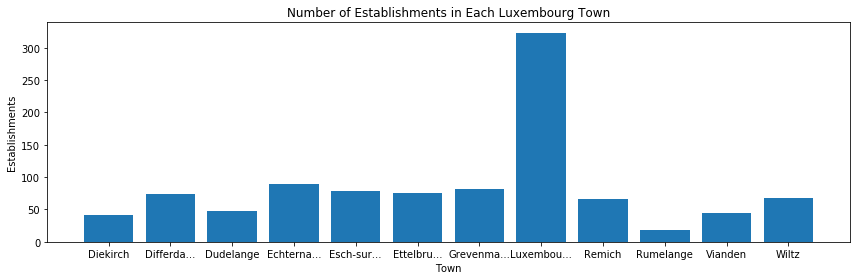

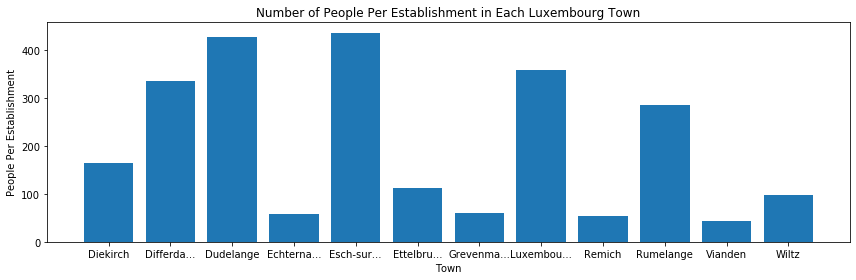

In [9]:
# Count number of places in each town
town_place_count = []
for town in places['Closest Town'].unique():
    count = places[places['Closest Town'] == town].shape[0]
    population = towns[towns['English Name'] == town].iloc[0]['Population']
    town_place_count.append((town, count, population))

# Plot number of places in each town
town_place_count.sort(key = lambda x: x[0])
plt.figure(figsize = (12, 4))
plt.bar(range(len(town_place_count)), [x[1] for x in town_place_count])
plt.xticks(range(len(town_place_count)), [x[0] if len(x[0]) < 10 else x[0][:8] + '...' for x in town_place_count])
plt.ylabel('Establishments')
plt.xlabel('Town')
plt.title('Number of Establishments in Each Luxembourg Town')
plt.tight_layout()
plt.show()

# Plot number of places per person
plt.figure(figsize = (12, 4))
plt.bar(range(len(town_place_count)), [x[2] / x[1] for x in town_place_count])
plt.xticks(range(len(town_place_count)), [x[0] if len(x[0]) < 10 else x[0][:8] + '...' for x in town_place_count])
plt.ylabel('People Per Establishment')
plt.xlabel('Town')
plt.title('Number of People Per Establishment in Each Luxembourg Town')
plt.tight_layout()
plt.show()

## Types of Places In Each Town

In [10]:
place_types = pd.read_csv('foursquare_place_type.csv', header = 0)
place_types.columns = ['Category', 'Category Type']
places = pd.merge(places, place_types, on='Category')

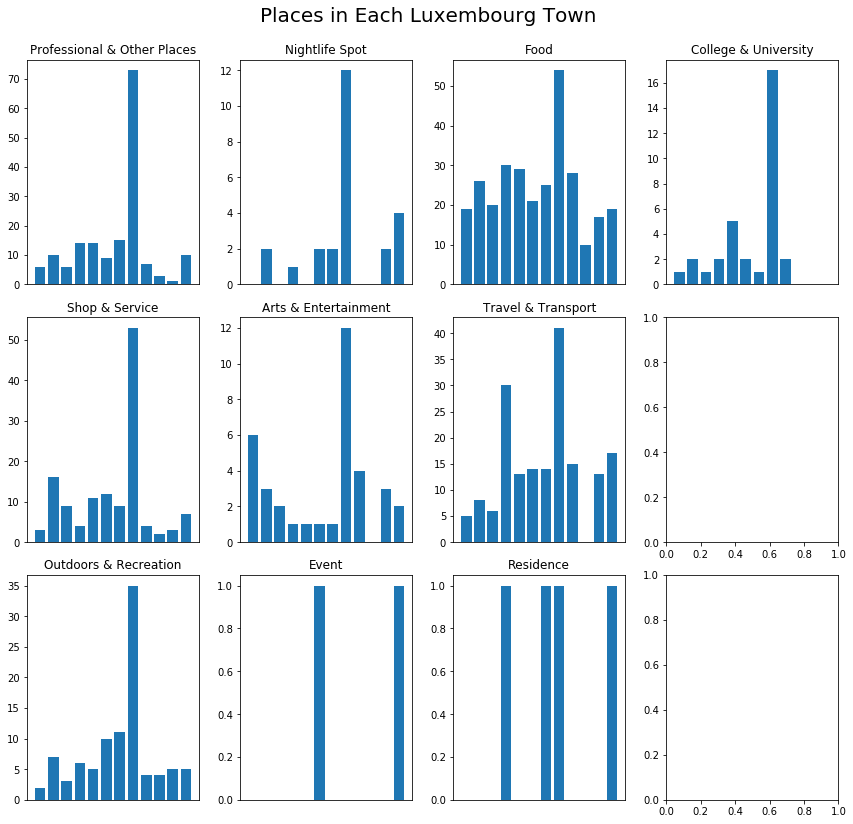

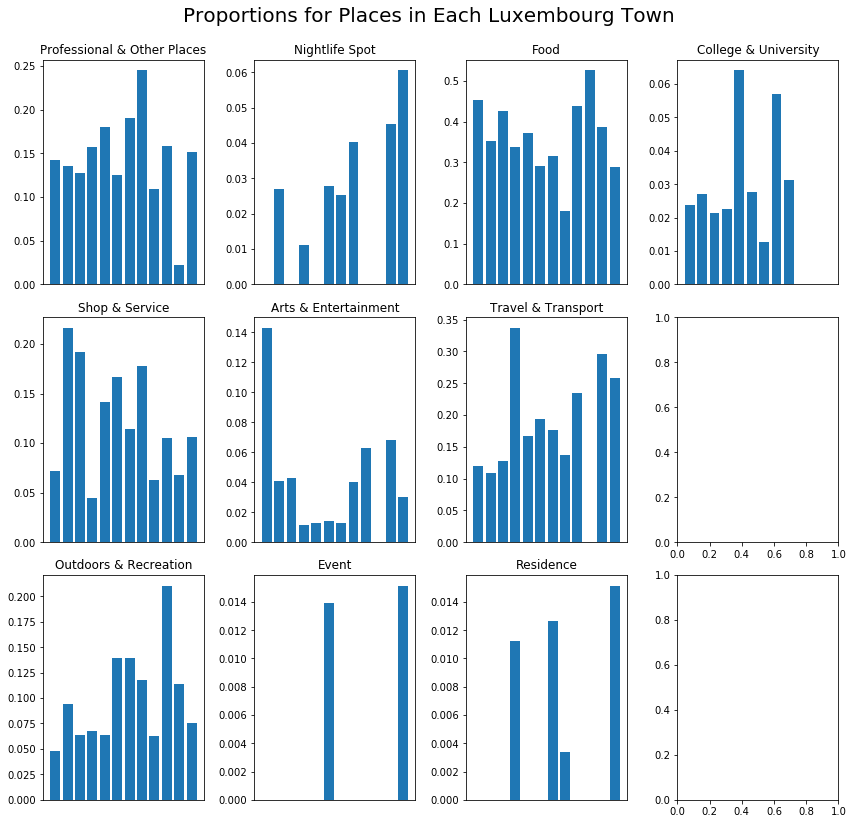

In [11]:
fig, axs = plt.subplots(3, 4, figsize = (12, 12))
#axs = [a for b in axs for a in b]

for ind, cat_type in enumerate(places['Category Type'].unique()):
    # Get places in that category type
    places_subset = places[places['Category Type'] == cat_type]
    
    # Count these places for each town
    town_place_count = []
    for town in places['Closest Town'].unique():
        count = places_subset[places_subset['Closest Town'] == town].shape[0]
        town_place_count.append((town, count))

    # Plot
    town_place_count.sort(key = lambda x: x[0])
    axs[ind % 3][ind // 3].bar(range(len(town_place_count)), [x[1] for x in town_place_count])
    axs[ind % 3][ind // 3].set_title(cat_type)
    axs[ind % 3][ind // 3].get_xaxis().set_visible(False)

fig.suptitle('Places in Each Luxembourg Town', fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

################################################################

fig, axs = plt.subplots(3, 4, figsize = (12, 12))
#axs = [a for b in axs for a in b]

for ind, cat_type in enumerate(places['Category Type'].unique()):
    # Get places in that category type
    places_subset = places[places['Category Type'] == cat_type]
    
    # Count these places for each town
    town_place_count = []
    for town in places['Closest Town'].unique():
        count = places_subset[places_subset['Closest Town'] == town].shape[0] / places[places['Closest Town'] == town].shape[0]
        town_place_count.append((town, count))

    # Plot
    town_place_count.sort(key = lambda x: x[0])
    axs[ind % 3][ind // 3].bar(range(len(town_place_count)), [x[1] for x in town_place_count])
    axs[ind % 3][ind // 3].set_title(cat_type)
    axs[ind % 3][ind // 3].get_xaxis().set_visible(False)

fig.suptitle('Proportions for Places in Each Luxembourg Town', fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Area and Population of Towns
The cells below check for correlation between the area and population between different towns in Luxembourg, however there does not appear to be any significant correlation.

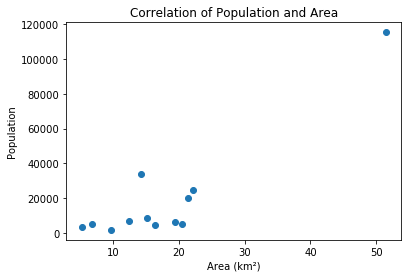

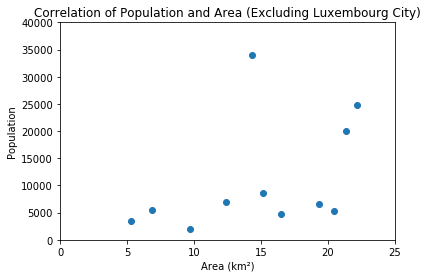

In [12]:
plt.scatter(towns['Area'], towns['Population'])
plt.xlabel('Area (km²)')
plt.ylabel('Population')
plt.title('Correlation of Population and Area')
plt.show()

# Repeated without Luxembourg City
plt.scatter(towns['Area'], towns['Population'])
plt.xlabel('Area (km²)')
plt.ylabel('Population')
plt.title('Correlation of Population and Area (Excluding Luxembourg City)')
plt.axis([0, 25, 0, 40000])
plt.show()

# Feature Extraction
The following cell is used to extract counts of each type of establishment for each town.

In [13]:
for ind, cat_type in enumerate(places['Category Type'].unique()):
    # Get places in that category type
    places_subset = places[places['Category Type'] == cat_type]
    
    # Count these places for each town
    new_feature = []
    for town in places['Closest Town'].unique():
        count = places_subset[places_subset['Closest Town'] == town].shape[0]
        new_feature.append(count)
    
    # Add to towns dataframe
    towns[cat_type + str(' Count')] = new_feature

The following cell is used to extract the proportion of each establishment type against the total number of establishments in each town.

In [14]:
for ind, cat_type in enumerate(places['Category Type'].unique()):
    # Get places in that category type
    places_subset = places[places['Category Type'] == cat_type]
    
    # Count these places for each town
    new_feature = []
    for town in places['Closest Town'].unique():
        count = places_subset[places_subset['Closest Town'] == town].shape[0] / places[places['Closest Town'] == town].shape[0]
        new_feature.append(count)
    
    # Add to towns dataframe
    towns[cat_type + ' Proportion'] = new_feature

The following cell is used to clean up the latitude and longitude features (make them numerical).

In [15]:
towns['Latitude'] = towns['Latitude'].apply(lambda x: x[:-2:])
towns['Longitude'] = towns['Longitude'].apply(lambda x: x[:-2:])

The following cell performs one-hot encoding on the Canton feature to create several new binary features.

In [16]:
for canton in towns['Canton'].unique():
    towns[canton + ' Canton'] = towns.apply(lambda x: 1 if x['Canton'] == canton else 0, axis = 1)

The numerical features are then extracted into _town_features_ and the names of each town into _town_names_.

In [17]:
towns_names = towns['English Name']
towns_features = towns.drop(['Canton', 'Date of Law', 'English Name', 'Luxembourgish Name', 'Wiki Link'], axis = 1)

Several of the features are scaled so that each feature has the same importance when comparing in the recommender system.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feats_to_scale = ['Area', 'Population', 'Latitude', 'Longitude', 'Professional & Other Places Count', 'Shop & Service Count',
                   'Outdoors & Recreation Count', 'Nightlife Spot Count', 'Arts & Entertainment Count', 'Event Count', 'Food Count',
                    'Travel & Transport Count', 'Residence Count', 'College & University Count']
towns_features[feats_to_scale] = scaler.fit_transform(towns_features[feats_to_scale])

The final features are shown in the cell below.

In [19]:
towns_features.head()

,Area,Population,Latitude,Longitude,Professional & Other Places Count,Shop & Service Count,Outdoors & Recreation Count,Nightlife Spot Count,Arts & Entertainment Count,Event Count,...,Residence Proportion,College & University Proportion,Diekirch Canton,Esch-sur-Alzette Canton,Echternach Canton,Grevenmacher Canton,Luxembourg Canton,Remich Canton,Vianden Canton,Wiltz Canton
0,-0.481756,-0.423420,1.006449,0.064049,-0.218925,-0.307145,-0.362763,0.594055,-0.318896,2.236068,...,0.015152,0.000000,1,0,0,0,0,0,0,0
1,0.372365,0.167277,-0.899417,-1.439162,3.229142,3.152939,3.166819,3.073591,2.870068,-0.447214,...,0.003356,0.057047,0,1,0,0,0,0,0,0
2,0.302355,0.008892,-1.113751,-0.352312,0.054731,-0.156707,0.343154,-0.025828,-0.637793,-0.447214,...,0.012658,0.012658,0,1,0,0,0,0,0,0
3,0.224469,-0.477744,0.695508,1.567071,-0.273656,0.068951,0.225501,-0.025828,-0.637793,2.236068,...,0.000000,0.027778,0,0,1,0,0,0,0,0
4,-0.312857,0.468547,-1.038817,-0.934877,-0.218925,0.369828,-0.127457,-0.025828,0.000000,-0.447214,...,0.000000,0.027027,0,1,0,0,0,0,0,0


# Recommender (Most Similar Towns)

In [20]:
from scipy.spatial import distance_matrix

towns_matrix = distance_matrix(towns_features, towns_features)
pd.DataFrame(towns_matrix, columns = towns_names, index = towns_names)

English Name,Diekirch,Differdange,Dudelange,Echternach,Esch-sur-Alzette,Ettelbruck,Grevenmacher,Luxembourg City,Remich,Rumelange,Vianden,Wiltz
English Name,,,,,,,,,,,,
Diekirch,0.000000,9.979070,4.028559,3.265391,4.702032,4.084962,4.649879,6.556426,4.937570,4.750778,3.659995,4.123144
Differdange,9.979070,0.000000,8.892508,10.282682,9.037458,10.364365,9.825300,10.993741,11.610629,9.549099,9.452105,10.342833
Dudelange,4.028559,8.892508,0.000000,4.612957,2.610017,4.066737,3.757865,5.129291,4.157874,2.991348,3.634314,4.116790
Echternach,3.265391,10.282682,4.612957,0.000000,4.565158,4.239311,3.425727,5.959162,4.247383,4.689266,4.508925,4.406556
Esch-sur-Alzette,4.702032,9.037458,2.610017,4.565158,0.000000,3.185155,3.553049,4.725635,3.793213,1.846377,4.591893,3.504174
Ettelbruck,4.084962,10.364365,4.066737,4.239311,3.185155,0.000000,3.489011,5.296944,3.561725,3.066864,4.144549,2.381826
Grevenmacher,4.649879,9.825300,3.757865,3.425727,3.553049,3.489011,0.000000,5.497930,3.284683,3.391146,3.740393,4.142573
Luxembourg City,6.556426,10.993741,5.129291,5.959162,4.725635,5.296944,5.497930,0.000000,5.991381,5.774971,6.628008,5.411300
Remich,4.937570,11.610629,4.157874,4.247383,3.793213,3.561725,3.284683,5.991381,0.000000,3.583664,4.967501,4.289091


In [21]:
def similar_towns(town, dist_mat = towns_matrix, n = 1):
    sim = []
    idx = towns_names[towns_names == town].index[0]
    score_series = pd.Series(dist_mat[idx]).sort_values(ascending = True)
    top_n = list(score_series.iloc[1:1 + n].index)
    for i in top_n:
        sim.append(towns_names[i])
    return sim

for town in towns_names:
    print(town + ' ' * (20 - len(town)) + similar_towns(town)[0])

Diekirch            Echternach
Differdange         Dudelange
Dudelange           Esch-sur-Alzette
Echternach          Diekirch
Esch-sur-Alzette    Rumelange
Ettelbruck          Wiltz
Grevenmacher        Remich
Luxembourg City     Esch-sur-Alzette
Remich              Grevenmacher
Rumelange           Esch-sur-Alzette
Vianden             Dudelange
Wiltz               Ettelbruck


The cell above shows the most similar town to every other town.

The cell below plots trees of the connections between similar towns. These trees produce four clusters to shows the four groups of similarities.

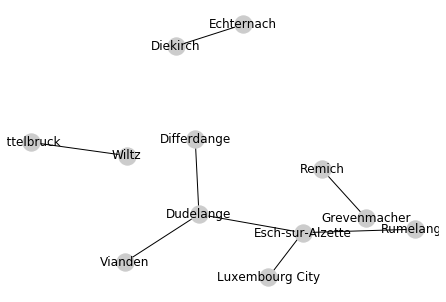

In [22]:
import networkx as nx

graph = nx.Graph()
for town in towns_names:
    graph.add_node(town)
for town in towns_names:
    graph.add_edge(town, similar_towns(town)[0])

nx.draw(graph, with_labels = True, node_color = '#cccccc', pos = nx.spring_layout(graph,k=0.3,iterations=20))
plt.show()